In [27]:
import math
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import matplotlib.pyplot as plt

In [28]:
# Issue. Check https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [29]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [30]:
# Constants and hyper-parameters
EPOCHS = 15
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VALID_SIZE = 10 #In percentage out of training set
CLASSES = 10
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [31]:
train_data, (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

split_point = math.floor((100-VALID_SIZE)*len(train_data[0])/100)
x_train, y_train = train_data[0][:split_point], train_data[1][:split_point]
x_valid, y_valid = train_data[0][split_point:], train_data[1][split_point:]

x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test  = x_test  / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_valid = x_valid[..., tf.newaxis].astype("float32")
x_test  = x_test[...,  tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
class FModel(tf.keras.Model):
    def __init__(self):
        super(FModel, self).__init__()
        
        self.network = tf.keras.Sequential([
            kl.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', use_bias=False),
            kl.BatchNormalization(axis=-1),
            kl.Dropout(rate=0.1),
            kl.ReLU(),
            kl.MaxPool2D(pool_size=2, strides=2, padding='valid'),
            
            kl.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', use_bias=False),
            kl.BatchNormalization(axis=-1),
            kl.Dropout(rate=0.1),
            kl.ReLU(),
            kl.MaxPool2D(pool_size=2, strides=2, padding='valid'),
            
            kl.Flatten(),
            
            kl.Dense(120, activation=None, use_bias=True),
            kl.Dropout(rate=0.1),
            kl.ReLU(),
            
            kl.Dense(84, activation=None, use_bias=True),
            kl.Dropout(rate=0.1),
            kl.ReLU(),
            
            kl.Dense(CLASSES, activation=None, use_bias=True)
        ])
        
    def call(self, x):
        return self.network(x)

In [33]:
fashionModel = FModel()

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

training_losses = []
validation_losses = []

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = fashionModel(images, training=True)
        loss = loss_function(labels, predictions)
    gradients = tape.gradient(loss, fashionModel.trainable_variables)
    optimizer.apply_gradients(zip(gradients, fashionModel.trainable_variables))

    train_loss(loss)
    
@tf.function
def evaluate_step(images, labels, loss_object, accuracy_object=None):
    predictions = fashionModel(images, training=False)
    loss = loss_function(labels, predictions)

    loss_object(loss)
    if accuracy_object:
        accuracy_object(labels, predictions)

Epoch 1,  Loss: 0.53,  Validation Loss: 0.37.
Epoch 2,  Loss: 0.37,  Validation Loss: 0.35.
Epoch 3,  Loss: 0.33,  Validation Loss: 0.30.
Epoch 4,  Loss: 0.30,  Validation Loss: 0.29.
Epoch 5,  Loss: 0.28,  Validation Loss: 0.30.
Epoch 6,  Loss: 0.27,  Validation Loss: 0.27.
Epoch 7,  Loss: 0.26,  Validation Loss: 0.28.
Epoch 8,  Loss: 0.25,  Validation Loss: 0.28.
Epoch 9,  Loss: 0.24,  Validation Loss: 0.26.
Epoch 10,  Loss: 0.23,  Validation Loss: 0.29.
Epoch 11,  Loss: 0.23,  Validation Loss: 0.27.
Epoch 12,  Loss: 0.22,  Validation Loss: 0.26.
Epoch 13,  Loss: 0.22,  Validation Loss: 0.27.
Epoch 14,  Loss: 0.21,  Validation Loss: 0.27.
Epoch 15,  Loss: 0.21,  Validation Loss: 0.26.


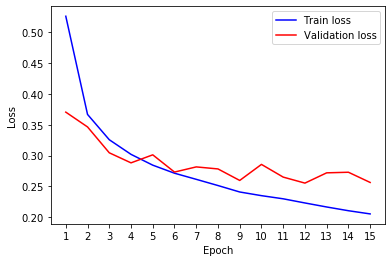

In [34]:
for epoch in range(EPOCHS):
    train_loss.reset_states()
    valid_loss.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
        
    evaluate_step(x_valid, y_valid, valid_loss)
    
    training_losses.append(train_loss.result())
    validation_losses.append(valid_loss.result())

    print('Epoch {}, '.format(epoch + 1),
          'Loss: {:.2f}, '.format(train_loss.result()),
          'Validation Loss: {:.2f}.'.format(valid_loss.result()))
    
plt.figure(0)
plt.plot(list(range(1,EPOCHS+1)), training_losses, 'b')
plt.plot(list(range(1,EPOCHS+1)), validation_losses, 'r')
plt.xticks(list(range(1,EPOCHS+1)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'])
plt.show()

In [35]:
test_loss.reset_states()
test_accuracy.reset_states()
evaluate_step(x_test, y_test, test_loss, test_accuracy)
print('Test Loss: {:.2f}, '.format(test_loss.result()),
      'Test Accuracy: {:.2f}%.'.format(test_accuracy.result() * 100))

Test Loss: 0.26,  Test Accuracy: 90.47%.


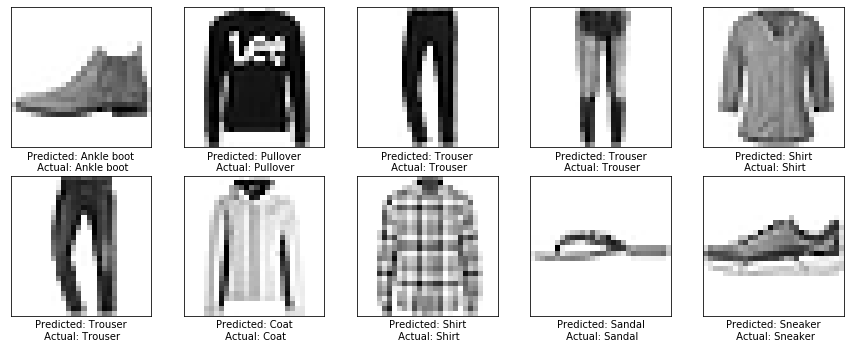

In [36]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i].squeeze(-1), cmap=plt.cm.binary)
    
    logits = fashionModel(x_test[i][np.newaxis,...], training=False)
    pred = np.argmax(logits)
    
    plt.xlabel('Predicted: '+CLASS_NAMES[pred]+'\n Actual: '+CLASS_NAMES[y_test[i]])
plt.show()